In [1]:
# !pip install osmapi
# !pip install pyrosm
# !pip install shapely==1.8.5

In [2]:
from tqdm import tqdm, trange
from collections import Counter

import geopandas as gpd
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import train_test_split, KFold
import optuna
from xgboost import XGBRegressor
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
orders = pd.read_csv('/kaggle/input/int20h-2023-hackathon/orders.csv')
nodes = pd.read_csv('/kaggle/input/int20h-2023-hackathon/nodes.csv')

In [4]:
nodes['nodes_speed'] = nodes.groupby('Id')['speed'].apply(lambda x: x.fillna(x.mean()))
nodes['nodes_time'] = nodes['distance'] / nodes['speed']

orders_distance = nodes.groupby('Id')[['distance']].sum().reset_index()
orders = orders.merge(orders_distance, on='Id')

orders_speed = nodes.groupby('Id')[['nodes_speed']].agg(('mean', 'median', 'min', 'max'))
orders_speed.columns = ['_'.join(col).strip() for col in orders_speed.columns.values]
orders = orders.merge(orders_speed, on='Id')

orders_time = nodes.groupby('Id')[['nodes_time']].agg(('sum', 'mean', 'median', 'min', 'max'))
orders_time.columns = ['_'.join(col).strip() for col in orders_time.columns.values]
orders = orders.merge(orders_time, on='Id')

orders['running_time'] = pd.to_datetime(orders['running_time'])
orders['completed_time'] = pd.to_datetime(orders['completed_time'])
orders['hour'] = orders['running_time'].dt.hour

## Weather data

In [5]:
weather = pd.read_excel('/kaggle/input/open-meteo-weather/weather.xlsx', header=3)
weather['time'] = weather['time'] + pd.DateOffset(hours=1)

orders['time'] = orders['running_time'].dt.floor('H')
orders = orders.merge(weather, on='time')

## OSM nodes data

In [6]:
nodes_info = pd.read_csv('/kaggle/input/openstreetmap-int20h/node_info.csv')
nodes_info = nodes_info[['@id', '@lat', '@lon']]
nodes_info.columns = ['node_id', 'lat', 'lon']
nodes_info['node_id'] = nodes_info['node_id'].astype(int)

bounding = gpd.read_file('/kaggle/input/openstreetmap-int20h/odesa_buff.geojson')
lon_mask = (nodes_info['lon'] > bounding['MINX'][0]) & (nodes_info['lon'] < bounding['MAXX'][0])
lat_mask = (nodes_info['lat'] > bounding['MINY'][0]) & (nodes_info['lat'] < bounding['MAXY'][0])
nodes_info = nodes_info[lon_mask & lat_mask].dropna()

#### Landmarks

In [7]:
landmarks = ['police', 'monument', 'college', 'hotel', 'arts_centre', 'embassy', 'mall', 'lighthouse', 'memorial',
             'fast_food', 'community_centre', 'theatre', 'university', 'garden_centre', 'jeweller', 'viewpoint',
             'courthouse', 'theme_park', 'department_store', 'furniture_shop', 'hospital', 'observation_tower',
             'town_hall', 'comms_tower', 'castle', 'tourist_info', 'zoo', 'sports_centre', 'cinema', 'clinic',
             'supermarket', 'public_building', 'car_dealership', 'attraction']

pois = gpd.read_file('/kaggle/input/openstreetmap-int20h/odesa_pois.geojson')
nodes_lon = np.radians(nodes_info['lon'].values)
nodes_lat = np.radians(nodes_info['lat'].values)

for landmark in landmarks:
    pois_lon = np.radians(pois[pois['fclass'] == landmark].geometry.x.values)
    pois_lat = np.radians(pois[pois['fclass'] == landmark].geometry.y.values)
    distances = haversine_distances(np.array((nodes_lat, nodes_lon)).T, np.array((pois_lat, pois_lon)).T).min(axis=1)
    nodes_info[f'{landmark}_dist'] = distances

#### Traffic

In [8]:
traffic = gpd.read_file('/kaggle/input/openstreetmap-int20h/odesa_traffic.geojson')

for category in traffic['fclass'].unique():
    cat_lon = np.radians(traffic[traffic['fclass'] == category].geometry.x.values)
    cat_lat = np.radians(traffic[traffic['fclass'] == category].geometry.y.values)
    distances = haversine_distances(np.array((nodes_lat, nodes_lon)).T, np.array((pois_lat, pois_lon)).T).min(axis=1)
    nodes_info[f'{category}_dist'] = distances

#### Density

In [9]:
nodes_info['geometry'] = gpd.points_from_xy(nodes_info['lon'], nodes_info['lat'], crs='EPSG:4326')

grid_01 = gpd.read_file('/kaggle/input/openstreetmap-int20h/grid_01.geojson')
nodes_grid_01 = gpd.GeoDataFrame(nodes_info[['node_id', 'geometry']]).sjoin(grid_01, how='inner', predicate='within')[['node_id', 'building_count', 'road_count', 'roads_length']]
nodes_grid_01.columns = ['node_id', 'building_count_01', 'road_count_01', 'roads_length_01']

grid_005 = gpd.read_file('/kaggle/input/openstreetmap-int20h/grid_005.geojson')
nodes_grid_005 = gpd.GeoDataFrame(nodes_info[['node_id', 'geometry']]).sjoin(grid_005, how='inner', predicate='within')[['node_id', 'building_count', 'road_count', 'roads_length']]
nodes_grid_005.columns = ['node_id', 'building_count_005', 'road_count_005', 'roads_length_005']

nodes_info = nodes_info.merge(nodes_grid_01, on='node_id')
nodes_info = nodes_info.merge(nodes_grid_005, on='node_id')

In [10]:
orders_nodes = nodes.groupby('Id')[['node_start', 'node_finish']].agg(lambda x: list(x)).reset_index()
orders_nodes['node_id'] = (orders_nodes['node_start'] + orders_nodes['node_finish']).apply(lambda x: list(set(x)))
orders_nodes = orders_nodes.drop(['node_start', 'node_finish'], axis=1)
orders_nodes = orders_nodes.explode('node_id')

orders_nodes = orders_nodes.merge(nodes_info, on='node_id', how='left')
orders_nodes = orders_nodes.drop(['node_id', 'lat', 'lon', 'geometry'], axis=1).groupby('Id').agg(('mean', 'min', 'median', 'max'))
orders_nodes.columns = ['_'.join(col).strip() for col in orders_nodes.columns.values]
orders_nodes = orders_nodes.reset_index()

orders = orders.merge(orders_nodes, on='Id')

In [11]:
# load_15 = pd.read_csv('/kaggle/input/openstreetmap-int20h/15_min_back_load.csv')
# load_15.columns = ['Id', 'load_15_mean', 'load_15_max', 'load_15_min', 'load_15_median']
# orders = orders.merge(load_15, on='Id')

In [12]:
# similar_time_delta_orders_aggs = pd.read_csv("/kaggle/input/similar-time-delta-orders-aggs/similar_time_delta_orders_aggs.csv",index_col=0)

In [13]:
# similar_time_delta_orders_aggs = similar_time_delta_orders_aggs.reset_index().rename(columns={'index':'Id'})

In [14]:
similar_time_orders_aggs = {}
for i in trange(len(orders)):
    order_by_previous_completed_orders = orders[((orders['running_time'].iloc[i]-pd.Timedelta(minutes=60))<orders['completed_time'])&(orders['completed_time']<orders['running_time'].iloc[i])]
    order_by_previous_completed_orders['delta_time'].median()
    similar_time_orders_aggs[orders.iloc[i]['Id']] = {
        'similar_time_delta_orders_mean':order_by_previous_completed_orders['delta_time'].mean(),
        'similar_time_delta_orders_median':order_by_previous_completed_orders['delta_time'].median()
    }
similar_time_orders_aggs = pd.DataFrame(similar_time_orders_aggs).T.reset_index().rename(columns={'index':'Id'})

100%|██████████| 5000/5000 [00:13<00:00, 377.09it/s]


In [15]:
orders = orders.merge(similar_time_orders_aggs,on='Id')

In [16]:
X = orders.drop(['Id', 'time', 'running_time', 'completed_time', 'delta_time'], axis=1)
y = orders['delta_time']

In [17]:
# hyper_params = {
#     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'rmse',
#     'feature_fraction': 0.75,
#     'reg_lambda': 1,
#     'reg_alpha': 1,
#     'learning_rate': 0.001,
#     'num_iterations': 12000
# }

# gbm = lgb.LGBMRegressor(**hyper_params)

In [18]:
tscv = TimeSeriesSplit(test_size=500)

In [19]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [20]:
import xgboost as xgb


def objective(trial, data=X, target=y):

    param = {
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [42]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'early_stopping_rounds': 100
    }
    
    cv_scores = []
    results_data = []
#     kf = KFold(n_splits=6, shuffle=True, random_state=42)
    for i,(train_index,val_index) in enumerate(tscv.split(X)):
    

#     for train_index, val_index in kf.split(X):
        X_train, y_train = X.iloc[train_index], y[train_index]
        X_val, y_val = X.iloc[val_index], y[val_index]
    
        model = xgb.XGBRegressor(**param)  
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        preds = model.predict(X_val)
        rmse = mean_squared_error(y_val, preds, squared=False)
        mae = mean_absolute_error(y_val, preds)
        r2 = r2_score(y_val, preds)
        results_data.append({'train_index':train_index,
                         'val_index':val_index,
                         'rmse':rmse,
                         'mae':mae,
                         'r2_score':r2,
                         'model':model})
        print(f'======SPLIT_{i}======')
        print(f"RMSE {rmse}")
        print(f"MAE {mae}")
        print(f"R2 {r2}")
    
    return np.mean(rmse)

In [21]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=12)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-03-05 08:12:09,958] A new study created in memory with name: no-name-985a4f4d-dc86-421e-abd8-07241b64737f


======SPLIT_0======
RMSE 141.09854556691175
MAE 115.217
R2 0.5711464577785466
======SPLIT_1======
RMSE 127.97289554327993
MAE 99.80344387817382
R2 0.6626075308419108
======SPLIT_2======
RMSE 112.77667504646996
MAE 90.05010986328125
R2 0.7161833736174001
======SPLIT_3======
RMSE 132.26390917476286
MAE 103.69279663085938
R2 0.6033835189221379


[I 2023-03-05 08:12:38,512] Trial 0 finished with value: 123.78277622882125 and parameters: {'lambda': 7.6933458724539605, 'alpha': 2.922227061682661, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 9, 'random_state': 42, 'min_child_weight': 290}. Best is trial 0 with value: 123.78277622882125.


======SPLIT_4======
RMSE 123.78277622882125
MAE 95.85704010009766
R2 0.6635945387251556
======SPLIT_0======
RMSE 134.69876619858672
MAE 108.749232421875
R2 0.6091670570743388
======SPLIT_1======
RMSE 125.48441477890205
MAE 97.69192398071289
R2 0.6756014003641359
======SPLIT_2======
RMSE 111.5796315623726
MAE 88.57915866088867
R2 0.7221764176668584
======SPLIT_3======
RMSE 132.44561332077208
MAE 103.39112976074219
R2 0.602293027008517


[I 2023-03-05 08:12:56,095] Trial 1 finished with value: 122.67962879442676 and parameters: {'lambda': 7.220962197050856, 'alpha': 1.2655557869533949, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 7, 'random_state': 42, 'min_child_weight': 215}. Best is trial 1 with value: 122.67962879442676.


======SPLIT_4======
RMSE 122.67962879442676
MAE 94.55186968994141
R2 0.6695638859427431
======SPLIT_0======
RMSE 129.44294824733214
MAE 103.62293975830079
R2 0.6390718798944927
======SPLIT_1======
RMSE 121.65058811060631
MAE 94.20204418945312
R2 0.695120785201321
======SPLIT_2======
RMSE 110.34555480021814
MAE 86.15571606445313
R2 0.7282879206583894
======SPLIT_3======
RMSE 131.94347669599813
MAE 103.01534899902343
R2 0.605302936781549


[I 2023-03-05 08:13:32,284] Trial 2 finished with value: 120.59452747709877 and parameters: {'lambda': 4.594343396425245, 'alpha': 8.617008240823514, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 17, 'random_state': 42, 'min_child_weight': 132}. Best is trial 2 with value: 120.59452747709877.


======SPLIT_4======
RMSE 120.59452747709877
MAE 93.08091577148437
R2 0.6807008222887356
======SPLIT_0======
RMSE 128.44021005094118
MAE 101.79556549072265
R2 0.6446421270586584
======SPLIT_1======
RMSE 121.94424903867616
MAE 94.91098342895508
R2 0.6936470697464083
======SPLIT_2======
RMSE 110.8759080410214
MAE 87.55392987060547
R2 0.7256697873995274
======SPLIT_3======
RMSE 130.5091338187846
MAE 101.5645538330078
R2 0.6138377088249694


[I 2023-03-05 08:13:45,058] Trial 3 finished with value: 119.68669282803197 and parameters: {'lambda': 3.630105907039016, 'alpha': 0.9282052443512439, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.016, 'max_depth': 13, 'random_state': 42, 'min_child_weight': 156}. Best is trial 3 with value: 119.68669282803197.


======SPLIT_4======
RMSE 119.68669282803197
MAE 92.81525592041015
R2 0.6854900907609789
======SPLIT_0======
RMSE 124.95792710013609
MAE 98.93013305664063
R2 0.6636499072808764
======SPLIT_1======
RMSE 120.82707295590839
MAE 93.22348849487305
R2 0.6992345809159874
======SPLIT_2======
RMSE 109.92621303020863
MAE 86.05062322998047
R2 0.7303491495545802
======SPLIT_3======
RMSE 131.70874649397
MAE 102.20988439941407
R2 0.6067060362442399


[I 2023-03-05 08:14:09,752] Trial 4 finished with value: 118.74347561158197 and parameters: {'lambda': 1.6657835463023916, 'alpha': 0.9175304844874317, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 13, 'random_state': 42, 'min_child_weight': 85}. Best is trial 4 with value: 118.74347561158197.


======SPLIT_4======
RMSE 118.74347561158197
MAE 90.90230438232422
R2 0.69042768644364
======SPLIT_0======
RMSE 130.00638065581944
MAE 103.47523956298828
R2 0.6359229839981557
======SPLIT_1======
RMSE 122.22040976493345
MAE 94.13762390136719
R2 0.6922579358436524
======SPLIT_2======
RMSE 109.74589941758227
MAE 85.81139199829101
R2 0.7312330486753752
======SPLIT_3======
RMSE 130.74850333388022
MAE 102.30445892333984
R2 0.6124198732053839


[I 2023-03-05 08:14:34,177] Trial 5 finished with value: 121.91819609989356 and parameters: {'lambda': 3.2906729626978786, 'alpha': 8.056675022014339, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 7, 'random_state': 42, 'min_child_weight': 44}. Best is trial 4 with value: 118.74347561158197.


======SPLIT_4======
RMSE 121.91819609989356
MAE 93.80748205566407
R2 0.6736529763361668
======SPLIT_0======
RMSE 121.28660049521172
MAE 95.3936376953125
R2 0.6831238342342172
======SPLIT_1======
RMSE 119.36644541785064
MAE 92.14720474243164
R2 0.7064622816107817
======SPLIT_2======
RMSE 109.48493144078395
MAE 85.31560919189454
R2 0.7325097464732342
======SPLIT_3======
RMSE 131.92775374498953
MAE 101.6222865600586
R2 0.6053969987691301


[I 2023-03-05 08:14:56,663] Trial 6 finished with value: 116.45083474606997 and parameters: {'lambda': 0.055502051577594635, 'alpha': 5.5492548377472035, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 11, 'random_state': 42, 'min_child_weight': 47}. Best is trial 6 with value: 116.45083474606997.


======SPLIT_4======
RMSE 116.45083474606997
MAE 89.01165731811524
R2 0.7022664252899584
======SPLIT_0======
RMSE 121.0891565759489
MAE 95.2729839477539
R2 0.684154687542895
======SPLIT_1======
RMSE 118.36868168052956
MAE 91.04962832641601
R2 0.7113490354647761
======SPLIT_2======
RMSE 109.32891770426036
MAE 85.71948892211914
R2 0.7332715393458143
======SPLIT_3======
RMSE 133.11178500614452
MAE 102.25745516967774
R2 0.5982822120785929


[I 2023-03-05 08:15:20,295] Trial 7 finished with value: 115.13336097173129 and parameters: {'lambda': 4.831635964481548, 'alpha': 6.170475808477091, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.012, 'max_depth': 7, 'random_state': 42, 'min_child_weight': 36}. Best is trial 7 with value: 115.13336097173129.


======SPLIT_4======
RMSE 115.13336097173129
MAE 87.05339422607422
R2 0.7089651710726815
======SPLIT_0======
RMSE 126.07319117827025
MAE 100.40305181884766
R2 0.6576191867649936
======SPLIT_1======
RMSE 120.125415611306
MAE 92.28070327758789
R2 0.7027176002340103
======SPLIT_2======
RMSE 109.68245569495886
MAE 85.73183639526367
R2 0.73154370533357
======SPLIT_3======
RMSE 130.20009573117323
MAE 101.1682721862793
R2 0.6156643635383519


[I 2023-03-05 08:15:39,148] Trial 8 finished with value: 118.44417989630625 and parameters: {'lambda': 2.912103479640765, 'alpha': 6.28106556320698, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 11, 'random_state': 42, 'min_child_weight': 31}. Best is trial 7 with value: 115.13336097173129.


======SPLIT_4======
RMSE 118.44417989630625
MAE 90.43572009277344
R2 0.6919862882728083
======SPLIT_0======
RMSE 132.69070996923256
MAE 106.38117401123047
R2 0.620733081563762
======SPLIT_1======
RMSE 124.25540419442919
MAE 96.85691256713868
R2 0.6819246861028363
======SPLIT_2======
RMSE 111.27814660936453
MAE 87.92210073852539
R2 0.7236757320208977
======SPLIT_3======
RMSE 133.01960179004834
MAE 103.57888616943359
R2 0.5988384185029552


[I 2023-03-05 08:16:07,515] Trial 9 finished with value: 121.07596487219462 and parameters: {'lambda': 8.201329384655539, 'alpha': 2.653961876289695, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 15, 'random_state': 42, 'min_child_weight': 279}. Best is trial 7 with value: 115.13336097173129.


======SPLIT_4======
RMSE 121.07596487219462
MAE 93.60680407714844
R2 0.6781463214642406
======SPLIT_0======
RMSE 125.96339980596413
MAE 99.5149761352539
R2 0.6582152546693572
======SPLIT_1======
RMSE 119.2943496955349
MAE 92.06523733520508
R2 0.7068167601701982
======SPLIT_2======
RMSE 110.5429750896567
MAE 86.10849621582031
R2 0.7273148055621748
======SPLIT_3======
RMSE 132.59760198377006
MAE 102.38129550170899
R2 0.601379721800704


[I 2023-03-05 08:16:18,727] Trial 10 finished with value: 117.99284840711178 and parameters: {'lambda': 6.63312620543495, 'alpha': 9.74155823863115, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.018, 'max_depth': 5, 'random_state': 42, 'min_child_weight': 112}. Best is trial 7 with value: 115.13336097173129.


======SPLIT_4======
RMSE 117.99284840711178
MAE 90.92147048950196
R2 0.6943291881363667
======SPLIT_0======
RMSE 118.17892006906546
MAE 93.0006127319336
R2 0.6991541940331156
======SPLIT_1======
RMSE 121.50360724573783
MAE 92.68943939208984
R2 0.695857063427519
======SPLIT_2======
RMSE 109.47126591591405
MAE 86.27400747680664
R2 0.7325765166951662
======SPLIT_3======
RMSE 133.67123710149468
MAE 103.56639001464843
R2 0.5948983773705312


[I 2023-03-05 08:18:53,081] Trial 11 finished with value: 116.23382328417306 and parameters: {'lambda': 0.664012445050769, 'alpha': 5.585232537765441, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.012, 'max_depth': 11, 'random_state': 42, 'min_child_weight': 1}. Best is trial 7 with value: 115.13336097173129.


======SPLIT_4======
RMSE 116.23382328417306
MAE 88.05474862670899
R2 0.7033750716145406
Number of finished trials: 12
Best trial: {'lambda': 4.831635964481548, 'alpha': 6.170475808477091, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.012, 'max_depth': 7, 'random_state': 42, 'min_child_weight': 36}


In [22]:
params_for_boost = study.best_trial.params
params_for_boost.update({
    'tree_method':'gpu_hist',
    'n_estimators': 10000,
    'early_stopping_rounds': 100
})

In [23]:
params_for_boost

{'lambda': 4.831635964481548,
 'alpha': 6.170475808477091,
 'colsample_bytree': 0.9,
 'subsample': 0.7,
 'learning_rate': 0.012,
 'max_depth': 7,
 'random_state': 42,
 'min_child_weight': 36,
 'tree_method': 'gpu_hist',
 'n_estimators': 10000,
 'early_stopping_rounds': 100}

In [24]:
model_best = xgb.XGBRegressor(**params_for_boost)  
X_train_, X_val_, y_train_, y_val_ = train_test_split(X, y, test_size=0.2, random_state=42)
history = model_best.fit(X_train_, y_train_,eval_set=[(X_val_, y_val_)])

[0]	validation_0-rmse:642.33742
[1]	validation_0-rmse:635.08774
[2]	validation_0-rmse:627.85624
[3]	validation_0-rmse:620.72390
[4]	validation_0-rmse:613.66806
[5]	validation_0-rmse:606.69913
[6]	validation_0-rmse:599.86086
[7]	validation_0-rmse:593.08290
[8]	validation_0-rmse:586.37770
[9]	validation_0-rmse:579.80621
[10]	validation_0-rmse:573.31166
[11]	validation_0-rmse:566.86997
[12]	validation_0-rmse:560.45246
[13]	validation_0-rmse:554.17052
[14]	validation_0-rmse:548.00438
[15]	validation_0-rmse:541.87173
[16]	validation_0-rmse:535.84137
[17]	validation_0-rmse:529.84574
[18]	validation_0-rmse:523.98913
[19]	validation_0-rmse:518.14888
[20]	validation_0-rmse:512.40205
[21]	validation_0-rmse:506.72958
[22]	validation_0-rmse:501.13492
[23]	validation_0-rmse:495.61836
[24]	validation_0-rmse:490.10796
[25]	validation_0-rmse:484.71019
[26]	validation_0-rmse:479.38528
[27]	validation_0-rmse:474.13854
[28]	validation_0-rmse:468.93269
[29]	validation_0-rmse:463.79791
[30]	validation_0-rm

In [25]:
results_from_train = model_best.evals_result()


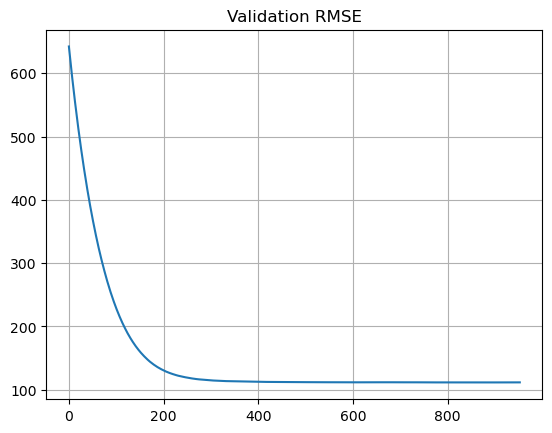

In [26]:
plt.plot(results_from_train['validation_0']['rmse'])
plt.grid()
plt.title('Validation RMSE')
plt.savefig('RMSE.png', bbox_inches='tight')

In [27]:
feature_importances = pd.Series(dict(zip(X_train_.columns,model_best.feature_importances_)))

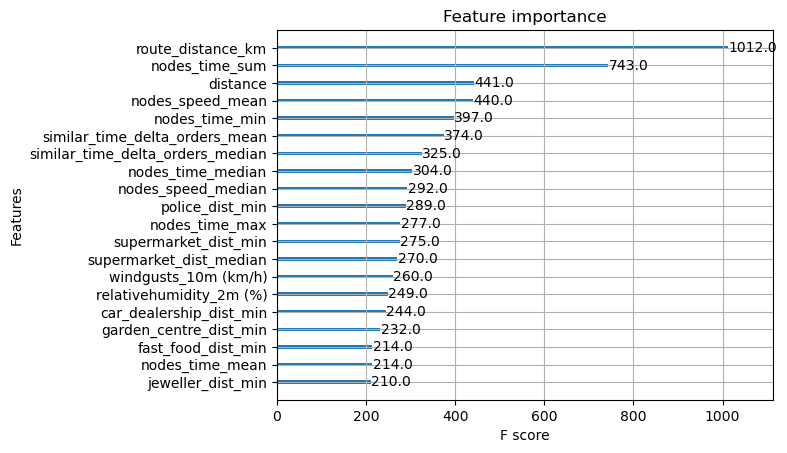

In [28]:
plot_importance(model_best,max_num_features=20)
plt.savefig('my_image.png', bbox_inches='tight')

In [29]:
orders_test = pd.read_csv('/kaggle/input/int20h-2023-hackathon/final_test.csv')
nodes_test = pd.read_csv('/kaggle/input/int20h-2023-hackathon/nodes_test.csv')
orders_test['running_time'] = pd.to_datetime(orders_test['running_time'])


In [30]:
similar_time_orders_aggs = {}
for i in trange(len(orders_test)):
    order_by_previous_completed_orders = orders[((orders_test['running_time'].iloc[i]-pd.Timedelta(minutes=60))<orders['completed_time'])&(orders['completed_time']<orders_test['running_time'].iloc[i])]
    order_by_previous_completed_orders['delta_time'].median()
    similar_time_orders_aggs[orders.iloc[i]['Id']] = {
        'similar_time_delta_orders_mean':order_by_previous_completed_orders['delta_time'].mean(),
        'similar_time_delta_orders_median':order_by_previous_completed_orders['delta_time'].median()
    }
similar_time_orders_aggs = pd.DataFrame(similar_time_orders_aggs).T.reset_index().rename(columns={'index':'Id'})

100%|██████████| 1000/1000 [00:02<00:00, 488.65it/s]


In [31]:
orders_test = orders_test.merge(similar_time_orders_aggs,on='Id',how='left')
nodes_test['nodes_speed'] = nodes_test.groupby('Id')['speed'].apply(lambda x: x.fillna(x.mean()))
nodes_test['nodes_time'] = nodes_test['distance'] / nodes_test['speed']

orders_distance = nodes_test.groupby('Id')[['distance']].sum().reset_index()
orders_test = orders_test.merge(orders_distance, on='Id')
orders_speed = nodes_test.groupby('Id')[['nodes_speed']].agg(('mean', 'median', 'min', 'max'))
orders_speed.columns = ['_'.join(col).strip() for col in orders_speed.columns.values]
orders_test = orders_test.merge(orders_speed, on='Id')
orders_time = nodes_test.groupby('Id')[['nodes_time']].agg(('sum', 'mean', 'median', 'min', 'max'))
orders_time.columns = ['_'.join(col).strip() for col in orders_time.columns.values]
orders_test = orders_test.merge(orders_time, on='Id')

orders_test['running_time'] = pd.to_datetime(orders_test['running_time'])
orders_test['hour'] = orders_test['running_time'].dt.hour

weather = pd.read_excel('/kaggle/input/open-meteo-weather/weather.xlsx', header=3)
weather['time'] = weather['time'] + pd.DateOffset(hours=1)
orders_test['time'] = orders_test['running_time'].dt.floor('H')
orders_test = orders_test.merge(weather, on='time')

orders_nodes = nodes_test.groupby('Id')[['node_start', 'node_finish']].agg(lambda x: list(x)).reset_index()
orders_nodes['node_id'] = (orders_nodes['node_start'] + orders_nodes['node_finish']).apply(lambda x: list(set(x)))
orders_nodes = orders_nodes.drop(['node_start', 'node_finish'], axis=1)
orders_nodes = orders_nodes.explode('node_id')
orders_nodes = orders_nodes.merge(nodes_info, on='node_id', how='left')
orders_nodes = orders_nodes.drop(['node_id', 'lat', 'lon', 'geometry'], axis=1).groupby('Id').agg(('mean', 'min', 'median', 'max'))
orders_nodes.columns = ['_'.join(col).strip() for col in orders_nodes.columns.values]
orders_nodes = orders_nodes.reset_index()
orders_test = orders_test.merge(orders_nodes, on='Id')

X_test = orders_test.drop(['Id', 'time', 'running_time'], axis=1)

In [38]:
X_test.shape

(1000, 259)

In [32]:
eta = model_best.predict(X_test)

In [35]:
orders_test = pd.read_csv('/kaggle/input/int20h-2023-hackathon/final_test.csv')
orders_test['prediction'] = eta
# orders_test.to_csv('su')

In [36]:
orders_test[['Id','prediction']].to_csv('submission.csv',index=False)

In [37]:
orders_test

,Id,running_time,route_distance_km,prediction
0,6198,2022-01-24 03:38:30,4.744,489.686340
1,6417,2022-01-24 03:45:51,6.279,534.503540
2,7054,2022-01-24 03:52:14,3.934,466.079376
3,9628,2022-01-24 04:03:21,5.959,544.705200
4,10283,2022-01-24 04:01:12,7.028,553.819885
...,...,...,...,...
995,525706,2022-01-24 18:46:17,2.897,372.546967
996,526604,2022-01-24 18:46:44,3.482,412.235413
997,527213,2022-01-24 18:47:25,3.486,403.916077
998,527520,2022-01-24 18:52:01,0.703,253.382416
